
Training CNN with L2=0.001, Dropout=0.2
Train Acc: 0.9158, Val Acc: 0.9134, Gap: 0.0024, Time: 1110.40s

Training CNN with L2=0.001, Dropout=0.5
Train Acc: 0.9008, Val Acc: 0.9144, Gap: -0.0136, Time: 1032.40s

Training CNN with L2=0.01, Dropout=0.2
Train Acc: 0.8599, Val Acc: 0.8667, Gap: -0.0068, Time: 1023.60s

Training CNN with L2=0.01, Dropout=0.5
Train Acc: 0.8364, Val Acc: 0.8623, Gap: -0.0259, Time: 1035.90s

Training CNN with L2=0.1, Dropout=0.2
Train Acc: 0.7555, Val Acc: 0.7792, Gap: -0.0237, Time: 2106.68s

Training CNN with L2=0.1, Dropout=0.5
Train Acc: 0.7183, Val Acc: 0.7463, Gap: -0.0280, Time: 1105.04s


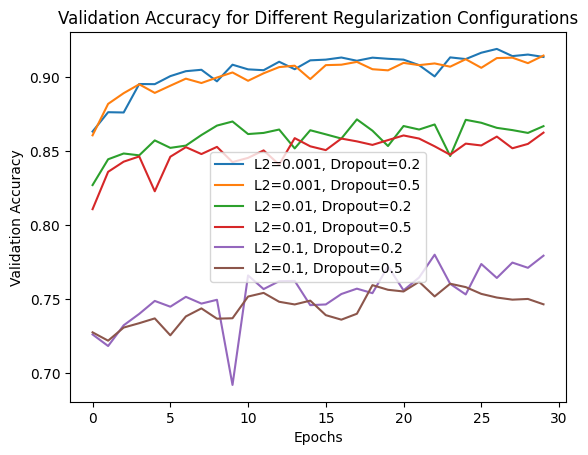

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import time
import matplotlib.pyplot as plt

# Load non-PCA (flattened) data
x_train = np.load('x_train_flat.npy')
x_val = np.load('x_val_flat.npy')
x_test = np.load('x_test_flat.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')

# Determine shape per sample (assumes square-like shape for CNN)
num_features = x_train.shape[1]
side_len = int(np.ceil(np.sqrt(num_features)))  # minimal square shape
new_size = side_len * side_len

# Pad if needed
def pad_to_square(x, new_size):
    pad_width = new_size - x.shape[1]
    return np.pad(x, ((0, 0), (0, pad_width)), mode='constant')

x_train_pad = pad_to_square(x_train, new_size)
x_val_pad = pad_to_square(x_val, new_size)
x_test_pad = pad_to_square(x_test, new_size)

# Reshape to 2D "image-like" data for CNN
side_len = int(np.sqrt(new_size))
x_train_cnn = x_train_pad.reshape(-1, side_len, side_len, 1)
x_val_cnn = x_val_pad.reshape(-1, side_len, side_len, 1)
x_test_cnn = x_test_pad.reshape(-1, side_len, side_len, 1)

input_shape = (side_len, side_len, 1)

# CNN model creation
def create_cnn_model(input_shape, l2_lambda=0.01, dropout_rate=0.5):
    model = keras.models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_lambda),
                      input_shape=input_shape, padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),

        layers.Conv2D(64, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_lambda),
                      padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),

        layers.Flatten(),
        layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')  # adjust for num of classes
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameter search
l2_lambdas = [0.001, 0.01, 0.1]
dropout_rates = [0.2, 0.5]

results = {}
all_histories = {}

# Training loop
for l2 in l2_lambdas:
    for dropout in dropout_rates:
        print(f"\nTraining CNN with L2={l2}, Dropout={dropout}")
        model = create_cnn_model(input_shape, l2_lambda=l2, dropout_rate=dropout)

        start_time = time.time()
        history = model.fit(x_train_cnn, y_train,
                            epochs=30,
                            validation_data=(x_val_cnn, y_val),
                            verbose=0)
        training_time = time.time() - start_time

        # Save results
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        val_loss = history.history['val_loss'][-1]

        results[(l2, dropout)] = {
            'train_acc': train_acc,
            'val_acc': val_acc,
            'val_loss': val_loss,
            'train_time': training_time,
            'overfit_gap': train_acc - val_acc
        }
        all_histories[(l2, dropout)] = history.history

        print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Gap: {train_acc - val_acc:.4f}, Time: {training_time:.2f}s")

# Plot validation accuracy
for (l2, dropout), history in all_histories.items():
    plt.plot(history['val_accuracy'], label=f'L2={l2}, Dropout={dropout}')
plt.title('Validation Accuracy for Different Regularization Configurations')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()
